<a href="https://colab.research.google.com/github/andreacangiani/NSPDE-ANA2024/blob/main/Python/CP6_worked.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finite Element Method in 1D - any order

Finite Element Method solver of any order $k$ for the 1D Poisson problem:

$-u''=f \quad \text{in } \Omega=(a,b)$

$u|_{\partial\Omega}=0$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import sympy as sym

In [2]:
# Gauss quadrature formula on [0,1]
def quadrature(n_quadrature_points):
  q, w = np.polynomial.legendre.leggauss(n_quadrature_points)
  return (q + 1) / 2, w / 2

In [3]:
# The reference element is [0,1]. We construct the mappings, the determinant of their Jacobians, and the reference Basis functions

def mapping(q, i):
    """
    Returns the mapping from [0,1] to T_k := [q[k], q[k+1]]
    """
    assert i < len(q) - 1
    assert i >= 0
    return lambda x: q[i] + x * (q[i+1] - q[i])

def mapping_J(q, i):
    assert i < len(q) - 1
    assert i >= 0
    return (q[i+1] - q[i])

def lagrange_basis(q, i):
    assert i < len(q)
    assert i >= 0
    return lambda x: np.prod([(x - q[j]) / (q[i] - q[j]) for j in range(len(q)) if i!=j], axis=0)

# Workaround, to allow lambdify to work also on constant expressions
def np_lambdify(varname, func):
    lamb = sym.lambdify(varname, func, modules=['numpy'])
    if func.is_constant():
        return lambda t: np.full_like(t, lamb(t))
    else:
        return lambda t: lamb(np.array(t))

def lagrange_basis_derivative(q, i, order=1):
    t = sym.var('t')
    return np_lambdify(t, lagrange_basis(q, i)(t).diff(t, order))

In [4]:
def mesh(omega,N):
  return np.linspace(omega[0], omega[1], N + 1)

FEM code any order

In [5]:
def FEM(omega,M,degree,n_qpoints,rhs):
  # 1D FEM with k=degree system matrix and rhs for
  # diffusion problem

  # Dimension of the problem
  N = M * degree +1

  vertices = mesh(omega, M) # grid

  # reference element (quadrature and Lagrange points)
  q, w = quadrature(n_qpoints)

  # lagrange_points are generated dynamically based on the polynomial degree.
  lagrange_points = np.linspace(0, 1, degree + 1)

  # evaluation of Lagrange basis at the quadrature points
  phi = np.array([lagrange_basis(lagrange_points, i)(q) for i in range(degree + 1)]).T
  dphi = np.array([lagrange_basis_derivative(lagrange_points, i)(q) for i in range(degree + 1)]).T

  # initialise system
  A = sp.lil_matrix((N, N))
  F = np.zeros(N)

  for i in range(M):
    JxW = mapping_J(vertices, i) * w
    ele_A = np.einsum('qi,qj,q', dphi, dphi, JxW) / mapping_J(vertices, i)**2
    ele_F = np.einsum('qi,q,q', phi, rhs(mapping(vertices, i)(q)), JxW)

    j = i * degree
    m = j + degree + 1
    A[j:m, j:m] += ele_A
    F[j:m] += ele_F

  return A, F

Apply boundary conditions

In [6]:
def apply_boundary_conditions(omega,A, F, g):
  # Ideally should scale entries as those of A
  N = A.shape[0] - 1
  A[0,A[0].nonzero()] = 0; A[0,0] = 1; F[0]=g(omega[0])
  A[N,A[N].nonzero()] = 0; A[N,N] = 1; F[N]=g(omega[1])

and solve

In [7]:
# Problem
omega = [0,np.pi]
rhs = lambda x: np.sin(x)
sol = lambda x: np.sin(x)

degree = 3 # degree of FEM basis
n_qpoints = 2 * degree - 1 # Number of quadrature points
no_experiments = 7 # Number of experiments

MM = np.zeros(no_experiments)
discrete_max_err = np.zeros(no_experiments)

for i in range(no_experiments):
  M = 2**(i + 2)
  MM[i] = M
  N = M * degree + 1

  A, F = FEM(omega, M, degree, n_qpoints, rhs) # call function computing FEM system
  apply_boundary_conditions(omega,A, F, sol)
  A_csr = A.tocsr()

  Uh = sp.linalg.spsolve(A_csr, F) # Solve the system

  # Compute exact solution
  x = np.linspace(omega[0], omega[1], N)
  U = sol(x)

  discrete_max_err[i] = max(abs(U - Uh)) # Compute discrete max norm error

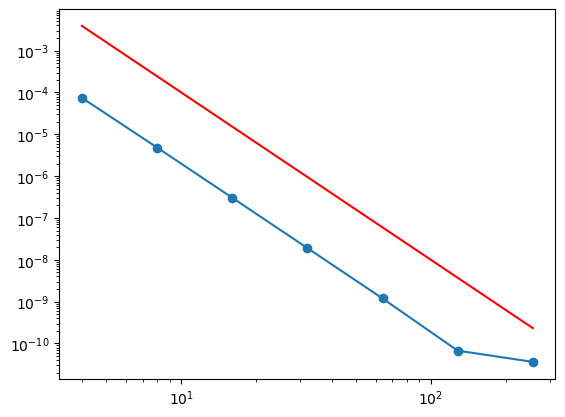

In [8]:
# Error loglog plots
plt.loglog(MM,discrete_max_err,'o-')
#plt.loglog(MM,interpola_H1_err**(1/2),'bd-')
plt.loglog(MM,MM**(-(degree+1)),'r')

In [9]:
print(MM)

[  4.   8.  16.  32.  64. 128. 256.]


**Exercise 1**: Write function computing $H^1$-norm error and test convergence for $k>1$.

In [21]:
def mesh_coarse(omega, M):
    a, b = omega
    return np.linspace(a, b, M + 1)  # M elements => M+1 coarse nodes

def mesh_fine(omega, M, degree):

    coarse_nodes = mesh_coarse(omega, M)
    nodes = []
    for i in range(M):
        xL = coarse_nodes[i]
        xR = coarse_nodes[i+1]
        # local nodal coordinates from [0,1] mapped to [xL, xR]
        local = np.linspace(xL, xR, degree + 1)
        # remove the left endpoint except for i=0, to avoid duplication
        if i > 0:
            local = local[1:]
        nodes.extend(local)
    return np.array(nodes)



def mapping(coarse_vertices, i):
    xL = coarse_vertices[i]
    xR = coarse_vertices[i+1]
    return lambda q: xL + (xR - xL)*q

def mapping_J(coarse_vertices, i):
    return coarse_vertices[i+1] - coarse_vertices[i]


In [ ]:
def H1_error(omega, M, degree, u_exact, uprime_exact, Uh, n_qpoints):

    coarse_vertices = mesh_coarse(omega, M)
    q, w = quadrature(n_qpoints)
    lagrange_nodes = np.linspace(0,1,degree+1)

    phi  = np.array([lagrange_basis(lagrange_nodes,i)(q) for i in range(degree+1)]).T
    
    dphi = np.array([lagrange_basis_derivative(lagrange_nodes,i)(q) for i in range(degree+1)]).T

    H1_sq = 0.0
    for elem in range(M):
        J = mapping_J(coarse_vertices, elem)
        xmap = mapping(coarse_vertices, elem)
        xq = xmap(q)
        wJ = w * J

        # Local solution + derivative
        start = elem*degree

        uh_loc = np.zeros_like(q)
        duh_loc = np.zeros_like(q)

        for j in range(degree+1):
            c = Uh[start+j]
            uh_loc   += c * phi[:, j]
            # derivative in real coords => (1/J)*dphi_j
            duh_loc  += c * (dphi[:, j] / J)

        e  = u_exact(xq)    - uh_loc
        de = uprime_exact(xq) - duh_loc

        H1_sq += np.sum(e**2 * wJ) + np.sum(de**2 * wJ)

    return np.sqrt(H1_sq)


def convergence(no_experiments, omega, degree, n_qpoints, exact, exact_prime, rhs):

    Mvals     = np.zeros(no_experiments, dtype=int)
    H1Err     = np.zeros(no_experiments)

    for i in range(no_experiments):
        M = 2**(i+2)
        Mvals[i] = M

        A, F = FEM(omega, M, degree, n_qpoints, rhs)
        apply_boundary_conditions(omega, A, F, exact)
        A_csr = A.tocsr()

        U_h = sp.linalg.spsolve(A_csr, F)

        # Evaluate error
        # "full mesh" = all N = M*degree+1 DOFs:
        node_coords = mesh_fine(omega, M, degree)

        H1Err[i] = H1_error(omega, M, degree, exact, exact_prime, U_h, n_qpoints)

    return Mvals, H1Err

def compute_slopes(X, Y):
    slope, _ = np.polyfit(np.log(X), np.log(Y), 1)
    return slope

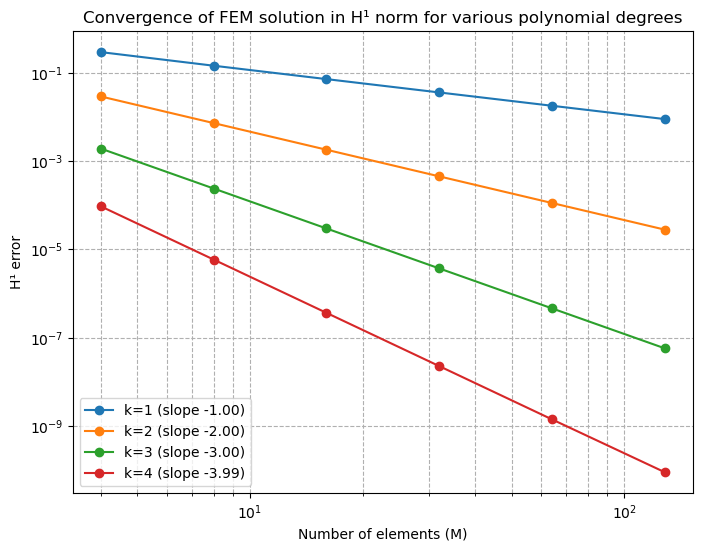

In [29]:
def test_fem_degrees():
    omega = [0, np.pi]
    # PDE: -u'' = sin(x) with u(x) = sin(x) (so homogeneous BC since sin(0)=sin(pi)=0)
    exact       = lambda x: np.sin(x)
    exact_prime = lambda x: np.cos(x)
    rhs         = lambda x: np.sin(x)
    
    no_experiments = 6
    degrees = [1, 2, 3, 4]
    
    plt.figure(figsize=(8,6))
    
    for degree in degrees:

        n_qpoints = 2 * degree + 1
        Mvals, H1= convergence(no_experiments, omega, degree, n_qpoints, exact, exact_prime, rhs)
        slope_H1 = compute_slopes(Mvals, H1)
        plt.loglog(Mvals, H1, 'o-', label=f'k={degree} (slope {slope_H1:.2f})')
    
    plt.xlabel('Number of elements (M)')
    plt.ylabel('H¹ error')
    plt.title("Convergence of FEM solution in H¹ norm for various polynomial degrees")
    plt.legend()
    plt.grid(True, which='both', ls='--')
    plt.show()

test_fem_degrees()